In [1]:
from osgeo import gdal,ogr,osr
from matplotlib import pyplot as plt, patches
import shapefile
import numpy as np

# Files used in the analysis 
rfile represents raster file of the Landsat 8 image. sfile is the shapefile of the marion reservoir. output is the raster file obtained from cropland data layer

In [2]:
rfile = r"C:\Users\abhiram\OneDrive - Oklahoma A and M System\Oklahoma State University\GRA\Water quality monitoring\Landsat\landsat\mr\LC08_L1TP_028033_20160627_20170222_01_T1_B5.TIF"
sfile = r"C:\Users\abhiram\OneDrive - Oklahoma A and M System\Oklahoma State University\GRA\Water quality monitoring\Landsat\marion_reprojected.shp"
output = r"C:\Users\abhiram\OneDrive - Oklahoma A and M System\Oklahoma State University\GRA\Water quality monitoring\Landsat\CDL_reprojected.tif"

(642536.6265, 30.019145759609483, 0.0, 4274720.6913, 0.0, -30.019145712443777)


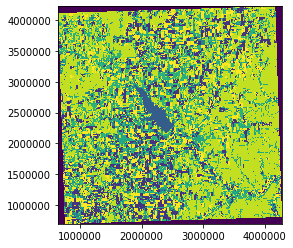

In [3]:
#opening CDL raster image using gdal and plotted using matplotlib
image = gdal.Open(output)

band_cdl = image.GetRasterBand(1)

array_cdl = band_cdl.ReadAsArray()

rows, cols = array_cdl.shape

geoTrans_cdl = image.GetGeoTransform()

print(geoTrans_cdl)

xi, yi, wi, ht = geoTrans_cdl[0], geoTrans_cdl[3], geoTrans_cdl[1], geoTrans_cdl[5]

xm = xi + cols*wi
ym = yi + rows*ht

extent = xi,yi,xm,ym

plt.imshow(array_cdl, extent = extent, cmap = plt.get_cmap('viridis'))


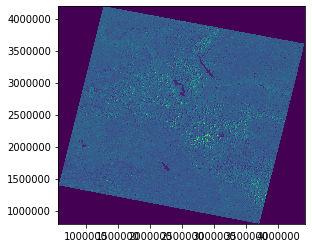

In [4]:
#opening landsat image using gdal and plotted using matplotlib
rimage = gdal.Open(rfile)

band = rimage.GetRasterBand(1)

rarray = band.ReadAsArray()

nrows,ncols = rarray.shape

geoTrans = rimage.GetGeoTransform()

x0,y0,w,h = geoTrans[0],geoTrans[3],geoTrans[1],geoTrans[5]

xmax = x0 + ncols*w
ymax = y0 + nrows*h

extent = x0,y0,xmax,ymax

plt.imshow(rarray, extent = extent, cmap = plt.get_cmap('viridis'))

(38.36110487196181, 38.455248514811196)

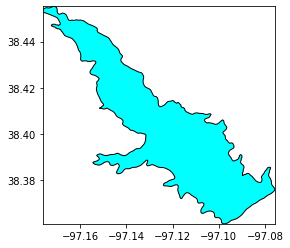

In [5]:
#reading shapefile using using pyshp and plotted using matplotlib

sf = shapefile.Reader(sfile)

%matplotlib inline

shape = sf.shape(0)

minx,miny,maxx,maxy = shape.bbox

fig = plt.figure()


points = []
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    point = [(i,j) for i,j in zip(x,y)]
    points.append(point)
    ax.add_patch(patches.Polygon(point, ec = 'k', fc = 'aqua'))
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

(4247455.619880274, 4258081.616443037)

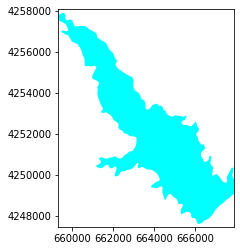

In [6]:
#transforming coordinates of shapefile into landsat coordinates
# get the source reference
driver = ogr.GetDriverByName('ESRI Shapefile')
dataset = driver.Open(sfile)
inSpatialRef = dataset.GetLayer().GetSpatialRef()
dataset = None

# get the destination reference
dataset = gdal.Open(rfile)
prj = dataset.GetProjection()
outSpatialRef = osr.SpatialReference(wkt=prj)
dataset = None

# create the transform
transform = osr.CoordinateTransformation(inSpatialRef, outSpatialRef)

new_points = []

%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111, aspect = 'equal')

for item in points:
    boundary = []
    for lon,lat in item:
        x,y,z = transform.TransformPoint(lon,lat)
        boundary.append((x,y))
    new_points.extend(boundary)
    #print(len(temp))
    ax.add_patch(patches.Polygon(boundary, fc = 'aqua'))
    

#Transforming the bounty box coordinates of the shapefile into landsat raster coordinates
xmi, ymi, dummy = transform.TransformPoint(minx, miny)
xma, yma, dummy = transform.TransformPoint(maxx, maxy)        

#Is there a way I can show the plot with out manually giving the bounds?
ax.set_xlim(xmi, xma)
ax.set_ylim(ymi, yma)

In [7]:
# clipping raster using the function to find the size of array
def world_to_pixel(geo_matrix, x, y):
    ul_x= geo_matrix[0]
    ul_y = geo_matrix[3]
    x_dist = geo_matrix[1]
    y_dist = geo_matrix[5]
    pixel = int((x - ul_x) / x_dist)
    line = -int((ul_y - y) / y_dist)
    return pixel, line

ulX, ulY = world_to_pixel(geoTrans,xmi, yma)
lrX, lrY = world_to_pixel(geoTrans,xma, ymi)

286
354


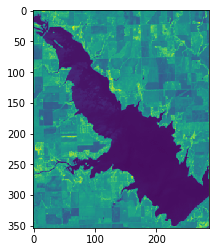

In [18]:
#clipping the raster of landsat using the transformed coordinates
pxWidth = int(lrX - ulX)
pxHeight = -int(ulY - lrY)
print(pxWidth)
print(pxHeight)
clip = rarray[ulY:lrY, ulX:lrX]
plt.imshow(clip)
plt.savefig("figure7_1.tif", dpi=300)

286
354


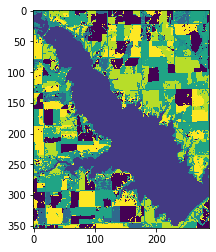

In [9]:
ulX, ulY = world_to_pixel(geoTrans_cdl,xmi, yma)
lrX, lrY = world_to_pixel(geoTrans_cdl,xma, ymi)
pxWidth = int(lrX - ulX)
pxHeight = -int(ulY - lrY)
print(pxWidth)
print(pxHeight)
clip_cdl = array_cdl[ulY:lrY, ulX:lrX]
plt.imshow(clip_cdl)

(354, 286)
1


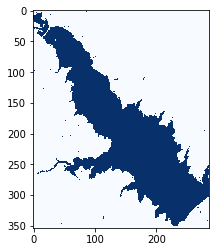

In [10]:
#masking the clipped CDL raster
mask = clip_cdl.copy()
mask[clip_cdl == 75] = 1
mask[clip_cdl != 75] = 0

plt.imshow(mask, cmap = plt.get_cmap('Blues'))
print(mask.shape)
print(mask.max())

(354, 286)
25699
0


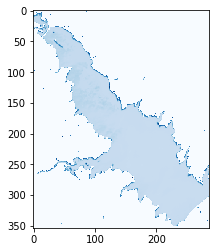

In [11]:
masked = clip*mask
plt.imshow(masked, cmap = plt.get_cmap('Blues'))
print(masked.shape)
print(masked.max())
print(masked.min())

In [12]:
#Read all the rasterfiles of Landsat
B1 = r"C:\Users\abhiram\OneDrive - Oklahoma A and M System\Oklahoma State University\GRA\Water quality monitoring\Landsat\landsat\mr\LC08_L1TP_028033_20160627_20170222_01_T1_B1.TIF"
B2 = r"C:\Users\abhiram\OneDrive - Oklahoma A and M System\Oklahoma State University\GRA\Water quality monitoring\Landsat\landsat\mr\LC08_L1TP_028033_20160627_20170222_01_T1_B2.TIF"
B3 = r"C:\Users\abhiram\OneDrive - Oklahoma A and M System\Oklahoma State University\GRA\Water quality monitoring\Landsat\landsat\mr\LC08_L1TP_028033_20160627_20170222_01_T1_B3.TIF"
B4 = r"C:\Users\abhiram\OneDrive - Oklahoma A and M System\Oklahoma State University\GRA\Water quality monitoring\Landsat\landsat\mr\LC08_L1TP_028033_20160627_20170222_01_T1_B4.TIF"
B6 = r"C:\Users\abhiram\OneDrive - Oklahoma A and M System\Oklahoma State University\GRA\Water quality monitoring\Landsat\landsat\mr\LC08_L1TP_028033_20160627_20170222_01_T1_B6.TIF"
B7 = r"C:\Users\abhiram\OneDrive - Oklahoma A and M System\Oklahoma State University\GRA\Water quality monitoring\Landsat\landsat\mr\LC08_L1TP_028033_20160627_20170222_01_T1_B7.TIF"
B8 = r"C:\Users\abhiram\OneDrive - Oklahoma A and M System\Oklahoma State University\GRA\Water quality monitoring\Landsat\landsat\mr\LC08_L1TP_028033_20160627_20170222_01_T1_B8.TIF"
B9 = r"C:\Users\abhiram\OneDrive - Oklahoma A and M System\Oklahoma State University\GRA\Water quality monitoring\Landsat\landsat\mr\LC08_L1TP_028033_20160627_20170222_01_T1_B9.TIF"
B10 = r"C:\Users\abhiram\OneDrive - Oklahoma A and M System\Oklahoma State University\GRA\Water quality monitoring\Landsat\landsat\mr\LC08_L1TP_028033_20160627_20170222_01_T1_B10.TIF"
B11 = r"C:\Users\abhiram\OneDrive - Oklahoma A and M System\Oklahoma State University\GRA\Water quality monitoring\Landsat\landsat\mr\LC08_L1TP_028033_20160627_20170222_01_T1_B11.TIF"


In [13]:
b1 = gdal.Open(B1)
band1 = b1.GetRasterBand(1)
b1arr = band1.ReadAsArray()
ulX, ulY = world_to_pixel(geoTrans,xmi, yma)
lrX, lrY = world_to_pixel(geoTrans,xma, ymi)
clip_b1arr = b1arr[ulY:lrY, ulX:lrX]

b2 = gdal.Open(B2)
band2 = b2.GetRasterBand(1)
b2arr = band2.ReadAsArray()
clip_b2arr = b2arr[ulY:lrY, ulX:lrX]

b3 = gdal.Open(B3)
band3 = b3.GetRasterBand(1)
b3arr = band3.ReadAsArray()
clip_b3arr = b3arr[ulY:lrY, ulX:lrX]

b4 = gdal.Open(B4)
band4 = b4.GetRasterBand(1)
b4arr = band4.ReadAsArray()
clip_b4arr = b4arr[ulY:lrY, ulX:lrX]

b5 = gdal.Open(rfile)
band5 = b5.GetRasterBand(1)
b5arr = band5.ReadAsArray()
clip_b5arr = b5arr[ulY:lrY, ulX:lrX]

b6 = gdal.Open(B6)
band6 = b6.GetRasterBand(1)
b6arr = band6.ReadAsArray()
clip_b6arr = b6arr[ulY:lrY, ulX:lrX]

b7 = gdal.Open(B7)
band7 = b7.GetRasterBand(1)
b7arr = band7.ReadAsArray()
clip_b7arr = b7arr[ulY:lrY, ulX:lrX]

b8 = gdal.Open(B8)
band8 = b8.GetRasterBand(1)
b8arr = band8.ReadAsArray()
clip_b8arr = b8arr[ulY:lrY, ulX:lrX]

b9 = gdal.Open(B9)
band9 = b9.GetRasterBand(1)
b9arr = band9.ReadAsArray()
clip_b9arr = b9arr[ulY:lrY, ulX:lrX]

b10 = gdal.Open(B10)
band10 = b10.GetRasterBand(1)
b10arr = band10.ReadAsArray()
clip_b10arr = b10arr[ulY:lrY, ulX:lrX]

b11 = gdal.Open(B11)
band11 = b11.GetRasterBand(1)
b11arr = band11.ReadAsArray()
clip_b11arr = b11arr[ulY:lrY, ulX:lrX]

In [14]:
algae = (-8.1121763*clip_b2arr) + (9.92743107*clip_b3arr) - (3.58093835*clip_b4arr) - (8.31266855*clip_b5arr) + (4.18871553*clip_b6arr) - (0.08014276*clip_b9arr) + (16.47417868*clip_b10arr) - (12.51797012*clip_b11arr) - (4.29451382*((clip_b6arr + clip_b7arr)/clip_b5arr)) + 12.11326051  
print(np.min(algae))

-42316.34777707699


Text(0.5, 1.0, 'Band 5')

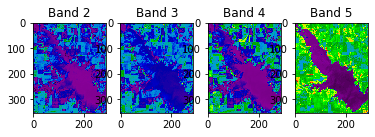

In [15]:
name = 'nipy_spectral'
fig, subs = plt.subplots(1,4)
subs[0].imshow(clip_b2arr, cmap = plt.get_cmap(name))
subs[0].set_title('Band 2')
subs[1].imshow(clip_b3arr, cmap = plt.get_cmap(name))
subs[1].set_title('Band 3')
subs[2].imshow(clip_b4arr, cmap = plt.get_cmap(name))
subs[2].set_title('Band 4')
subs[3].imshow(clip_b5arr, cmap = plt.get_cmap(name))
subs[3].set_title('Band 5')

Text(0.5, 1.0, 'Band 11')

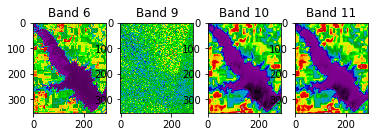

In [16]:
fig, subs = plt.subplots(1,4)
subs[0].imshow(clip_b6arr, cmap = plt.get_cmap(name))
subs[0].set_title('Band 6')
subs[1].imshow(clip_b9arr, cmap = plt.get_cmap(name))
subs[1].set_title('Band 9')
subs[2].imshow(clip_b10arr, cmap = plt.get_cmap(name))
subs[2].set_title('Band 10')
subs[3].imshow(clip_b11arr, cmap = plt.get_cmap(name))
subs[3].set_title('Band 11')

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


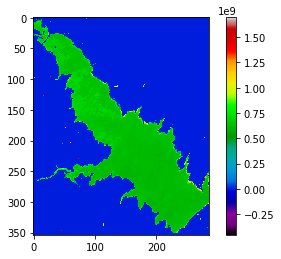

In [17]:
algae_masked = algae*masked
print(algae_masked)
plt.imshow(algae_masked, cmap = plt.get_cmap(name))
plt.colorbar()
plt.savefig("figure7.tif", dpi = 300)